In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from filterpy.kalman import KalmanFilter
from filterpy.common import kinematic_kf
from tracking import ConstantUpdatePolicy, ResidualUpdatePolicy, RandomUpdatePolicy
from radar import Radar2D
from target import SingerModelMD
from simulation import simulation_loop
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [3]:
# Common parameters
dt = 0.01
horizon = 10000
t = dt*np.arange(horizon)

In [4]:
# Create simulation objects

target = SingerModelMD(
    stdAcc=0.4, 
    corrAcc=0.5, 
    x0=np.array([[5e3, -1e2, 0, 5e3, 1e2, 0]]), 
    dim=2, 
    dt=dt,
    rcs=1
)

tracker = kinematic_kf(
    dim=2, 
    order=2,
    dt=0.1
)

radar = Radar2D(
    sn0=50,
    beamwidth=np.pi/64,
    prob_f=1e-8,
    order=2,
)

update_policy = ConstantUpdatePolicy(20)

In [5]:
# Initialize parameters
def initialize():
    target.reset()
    tracker.x = target.x
    tracker.P = 100*np.eye(6)
    tracker.Q = np.diag(np.linalg.eig(target.Q)[0])
    update_policy.reset()

In [6]:
initialize()
data = simulation_loop(target, radar, tracker, update_policy, horizon)

<IPython.core.display.Javascript object>


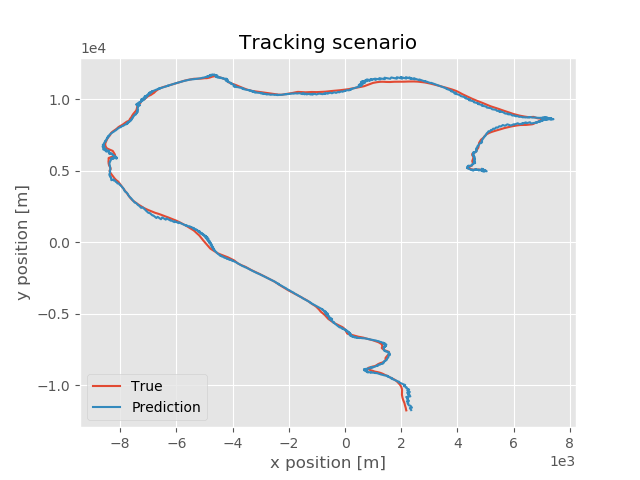

In [17]:
plt.figure()
plt.plot(data.states[:, 0], data.states[:, 3], '-', label='True')
plt.plot(data.predictions[:, 0], data.predictions[:, 3], '-', label='Prediction')
# plt.plot([data.measurements[i].z[0] for i in range(len(data.measurements))], [data.measurements[i].z[1] for i in range(len(data.measurements))], 'x')
plt.grid(True)
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')
plt.ticklabel_format( axis='both', style='sci', scilimits=np.array([0, 0]))
plt.title('Tracking scenario')
plt.legend()
plt.show()
plt.savefig('figs/scenario.pdf', bbox='tight', format='pdf')

<IPython.core.display.Javascript object>


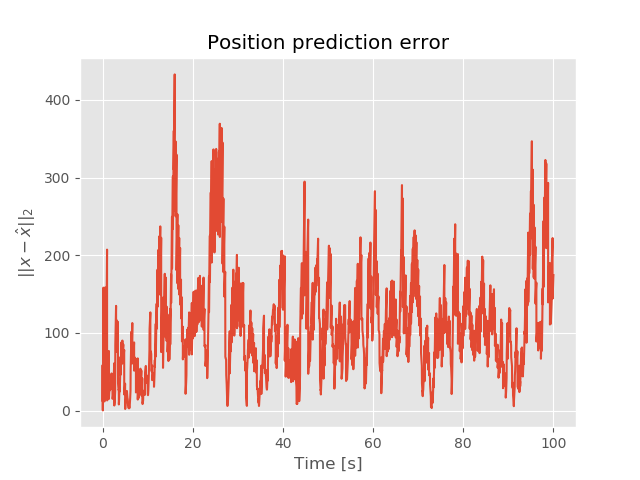

In [8]:
pred_error = np.linalg.norm(data.states[:, [0, 3]] - data.predictions[:, [0, 3]], axis=1)
plt.figure()
plt.plot(t, pred_error)
plt.xlabel('Time [s]')
plt.ylabel('$|| x - \hat{x} ||_2$')
plt.title('Position prediction error')
plt.grid(True)
plt.show()
plt.savefig('figs/position_error.pdf', bbox='tight', format='pdf')

<IPython.core.display.Javascript object>


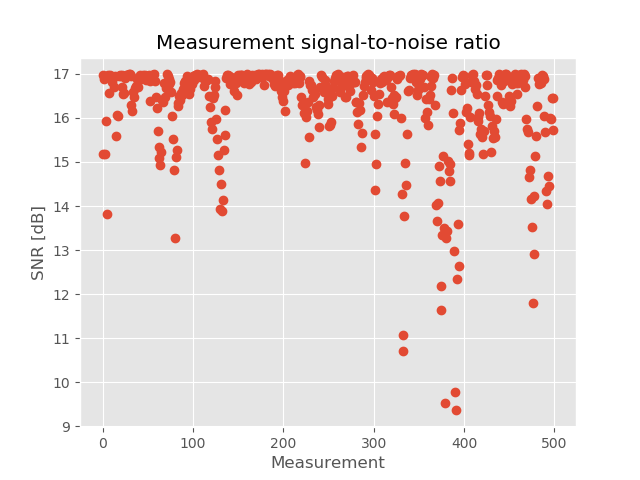

In [9]:
plt.figure()
plt.plot(10*np.log10([data.measurements[idx].SNR for idx in range(len(data.measurements))]), 'o')
plt.title('Measurement signal-to-noise ratio')
plt.ylabel('SNR [dB]')
plt.xlabel('Measurement')
plt.grid(True)
plt.savefig('figs/snr.pdf', bbox='tight', format='pdf')

<IPython.core.display.Javascript object>


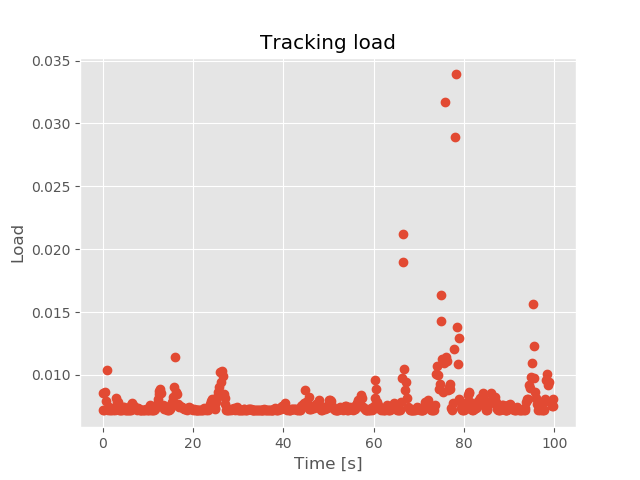

In [10]:
plt.figure()
load = np.array([data.measurements[idx].n_dwells for idx in range(len(data.measurements))]) * 0.001 / (data.revisit_intervals*dt)

plt.plot(t[data.update_indexes], load, 'o')
plt.ylabel('Load')
plt.xlabel('Time [s]')
plt.grid(True)
plt.title('Tracking load')
plt.savefig('figs/load.pdf', bbox='tight', format='pdf')

<IPython.core.display.Javascript object>


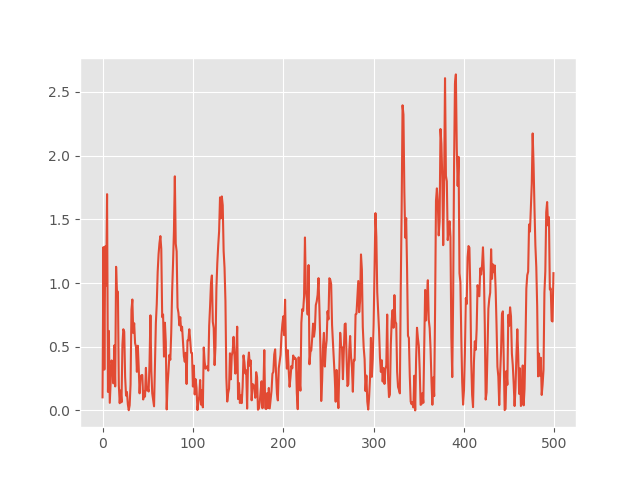

In [11]:
plt.figure()
plt.plot([data.measurements[i].angular_error/np.pi*180 for i in range(len(data.measurements))])

In [12]:
radar.beamwidth / np.pi * 180

2.8125

In [13]:
np.mean([data.measurements[i].angular_error/np.pi*180 for i in range(len(data.measurements))])

0.6162947601636718

In [14]:
radar.beamwidth/np.pi*180

2.8125

<IPython.core.display.Javascript object>


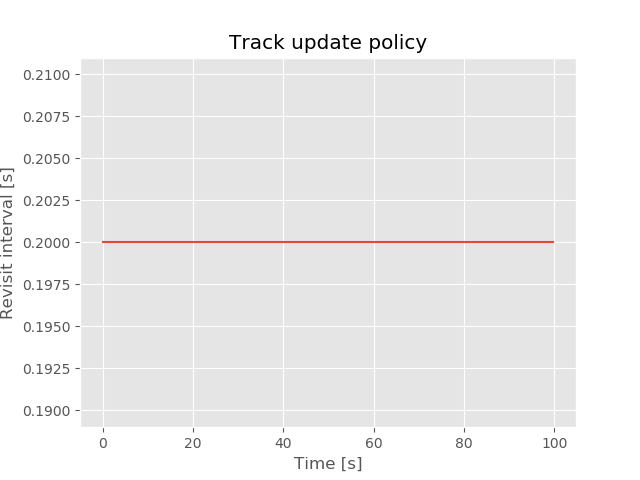

In [15]:
plt.figure()

plt.plot(t[data.update_indexes], data.revisit_intervals*dt, '-')
plt.xlabel('Time [s]')
plt.ylabel('Revisit interval [s]')
plt.title('Track update policy')
plt.grid(True)
plt.savefig('figs/update_policy.pdf', bbox='tight', format='pdf')